In [0]:
import torch
import torch.nn as nn
from google.colab import drive
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.autograd import Variable
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

In [44]:
data_dir = 'gdrive/My Drive/Assignment 5 Dataset/'
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [45]:
#Define transforms for the training data and testing data
train_transforms = transforms.Compose([transforms.RandomRotation(30),
                                       transforms.RandomResizedCrop(224),
                                       transforms.RandomHorizontalFlip(),
                                       transforms.ToTensor(),
                                       transforms.Normalize([0.485, 0.456, 0.406],
                                                            [0.229, 0.224, 0.225])])

validation_transforms = transforms.Compose([transforms.Resize(256),
                                      transforms.CenterCrop(224),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.485, 0.456, 0.406],
                                                           [0.229, 0.224, 0.225])])


test_transforms = transforms.Compose([transforms.Resize(256),
                                      transforms.CenterCrop(224),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.485, 0.456, 0.406],
                                                           [0.229, 0.224, 0.225])])

#pass transform here-in
train_data = datasets.ImageFolder(data_dir + '/train', transform=train_transforms)
validation_data = datasets.ImageFolder(data_dir + '/validation', transform=validation_transforms)
test_data = datasets.ImageFolder(data_dir + '/test', transform=test_transforms)

#data loaders
trainloader = torch.utils.data.DataLoader(train_data, batch_size=64, shuffle=True)
validationloader = torch.utils.data.DataLoader(validation_data, batch_size=64, shuffle=True)
testloader = torch.utils.data.DataLoader(test_data, batch_size=64, shuffle=True)

print("Classes: ")
class_names = train_data.classes
print(class_names)

Classes: 
['infected', 'normal']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


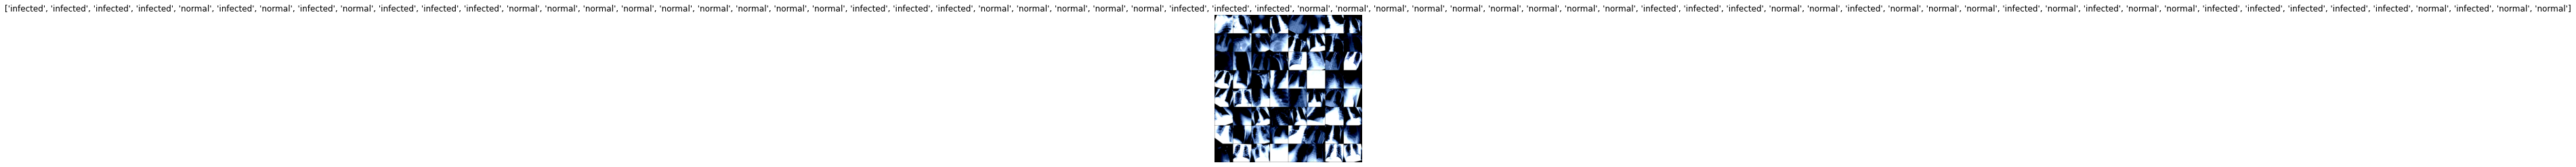

In [30]:
def imshow(inp, title=None):
    inp = inp.numpy().transpose((1, 2, 0))
    plt.axis('off')
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)

def show_databatch(inputs, classes):
    out = torchvision.utils.make_grid(inputs)
    imshow(out, title=[class_names[x] for x in classes])

# Get a batch of training data
inputs, classes = next(iter(trainloader))
show_databatch(inputs, classes)

In [31]:
vgg16 = models.vgg16(pretrained=True)
resnet18 = models.resnet18(pretrained=True)
print(vgg16)
print('Output Layer of VGG16 : ', vgg16.classifier[6].out_features) # 1000
print('\n\n<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<   ResNet-18   >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>\n')
print('\n',resnet18)
print('Output Layer of resnet18 : ', resnet18.fc.out_features) # 1000

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [0]:
# Freeze training for all layers
for param in vgg16.features.parameters():
    param.require_grad = False

In [0]:
# Freeze training for all layers above FC in ResNet18
child_counter = 0
for child in resnet18.children():
   #print(" child", child_counter, "is:")
   #print(child)
   child_counter += 1
   if child_counter < 9:
     for param in child.parameters():
        param.requires_grad = False


In [0]:
#num_features_0 = vgg16.classifier[0].in_features

features = [nn.Linear(in_features=25088, out_features=540, bias=True), nn.ReLU(inplace=True), nn.Dropout(p=0.5, inplace=False), nn.Linear(in_features=540, out_features=2, bias=True)]
print(features)

[Linear(in_features=25088, out_features=540, bias=True), ReLU(inplace=True), Dropout(p=0.5, inplace=False), Linear(in_features=540, out_features=2, bias=True)]


In [0]:
vgg16.classifier = nn.Sequential(*features)
print(vgg16)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [34]:
resnet18.fc = nn.Sequential(nn.Linear(512,540), nn.Linear(540, 2))
print(resnet18)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

## **VGG-16**

In [0]:
Epochs = 10
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(vgg16.parameters(), lr=0.001, momentum=0.9)

In [0]:
from tqdm import tqdm

#if you have gpu then you need to convert the network and data to cuda
#the easiest way is to first check for device and then convert network and data to device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
vgg16.to(device)

vgg16.train()
losses = []
for epoch in range(Epochs):  # loop over the dataset multiple times

    running_loss = 0.0
    pbar = tqdm(enumerate(trainloader))
    for i, data in pbar:
        # get the inputs
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()
        # In PyTorch, we need to set the gradients to zero before starting to do backpropragation 
        # because PyTorch accumulates the gradients on subsequent backward passes. 
        # This is convenient while training RNNs. 
        # So, the default action is to accumulate the gradients on every loss.backward() call

        # forward + backward + optimize
        outputs = vgg16(inputs)               #----> forward pass
        loss = criterion(outputs, labels)   #----> compute loss
        loss.backward()                     #----> backward pass
        optimizer.step()                    #----> weights update

        # print statistics
        running_loss += loss.item()

        pbar.set_description(
            'Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, i * len(inputs), len(trainloader.dataset),
                100. * i / len(trainloader),
                loss.data))
    
    epoch_loss = running_loss / len(trainloader)
    losses.append(epoch_loss)

    torch.save(vgg16.state_dict(), 'vgg16_FC_Only.pth')

print('Finished Training')

Train Epoch: 0 [9300/11954 (99%)]	Loss: 0.194420: : 187it [1:58:36, 38.06s/it]
Train Epoch: 1 [9300/11954 (99%)]	Loss: 0.345575: : 187it [06:09,  1.98s/it]
Train Epoch: 2 [9300/11954 (99%)]	Loss: 0.251531: : 187it [05:57,  1.91s/it]
Train Epoch: 3 [9300/11954 (99%)]	Loss: 0.284419: : 187it [05:54,  1.90s/it]
Train Epoch: 4 [9300/11954 (99%)]	Loss: 0.218387: : 187it [05:53,  1.89s/it]
Train Epoch: 5 [9300/11954 (99%)]	Loss: 0.120584: : 187it [05:53,  1.89s/it]
Train Epoch: 6 [9300/11954 (99%)]	Loss: 0.260387: : 187it [05:47,  1.86s/it]
Train Epoch: 7 [9300/11954 (99%)]	Loss: 0.202028: : 187it [05:48,  1.86s/it]
Train Epoch: 8 [9300/11954 (99%)]	Loss: 0.147246: : 187it [05:46,  1.85s/it]
Train Epoch: 9 [9300/11954 (99%)]	Loss: 0.195815: : 187it [05:55,  1.90s/it]


Finished Training


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


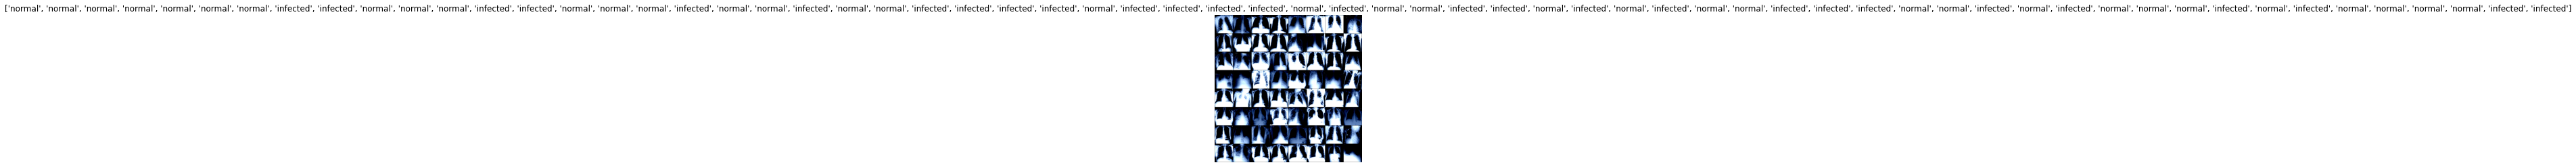

In [0]:
dataiter = iter(testloader)
images, labels = dataiter.next()
show_databatch(images, labels)

In [0]:
images, labels = images.to(device), labels.to(device) #-->convert test image to cuda (if available)
outputs = vgg16(images)                               #--> forward pass
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join('%5s' % class_names[predicted[j]]
                              for j in range(len(images))))
print('Ground Truth: ', ' '.join('%5s' % class_names[labels[j]]
                              for j in range(len(images))))

Predicted:  normal normal normal normal normal normal normal infected normal normal normal normal infected infected normal normal normal infected normal normal infected normal normal infected infected infected infected normal infected infected infected infected normal infected normal normal infected infected normal infected normal infected normal normal infected infected infected normal normal infected infected infected normal normal normal infected normal infected normal normal normal normal normal infected
Ground Truth:  normal normal normal normal normal normal normal infected infected normal normal normal infected infected normal normal normal infected normal normal infected normal normal infected infected infected infected normal infected infected infected infected normal infected normal normal infected infected normal infected normal infected normal normal infected infected infected normal normal infected normal infected normal normal normal infected normal infected normal normal

In [0]:
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = vgg16(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 1500 test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the 1500 test images: 96 %


In [0]:
nb_classes = 2

confusion_matrix = torch.zeros(nb_classes, nb_classes)
with torch.no_grad():
    for i, (inputs, classes) in enumerate(trainloader):
        inputs = inputs.to(device)
        classes = classes.to(device)
        outputs = vgg16(inputs)
        _, preds = torch.max(outputs, 1)
        for t, p in zip(classes.view(-1), preds.view(-1)):
                confusion_matrix[t.long(), p.long()] += 1

print(confusion_matrix)

tensor([[4619.,  300.],
        [ 717., 6318.]])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


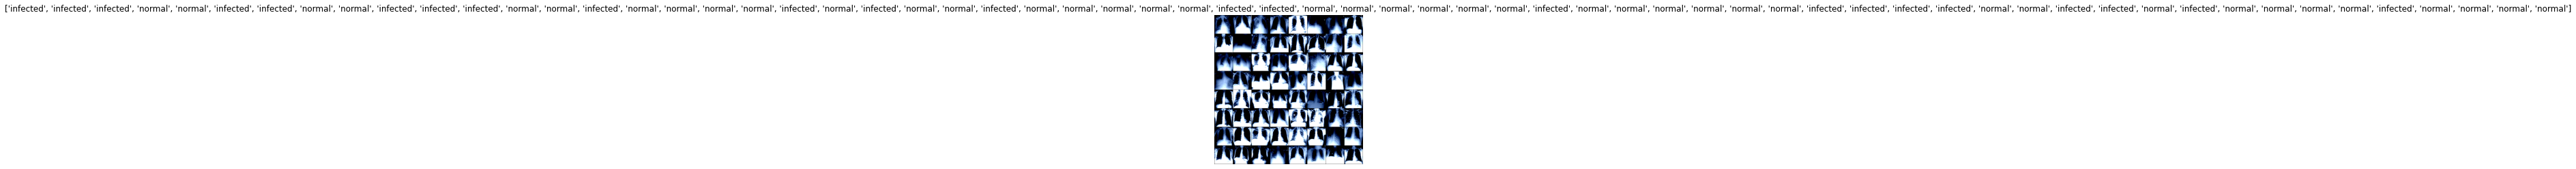

In [0]:
dataiter = iter(validationloader)
images, labels = dataiter.next()
show_databatch(images, labels)

In [0]:
images, labels = images.to(device), labels.to(device) #-->convert test image to cuda (if available)
outputs = vgg16(images)                               #--> forward pass
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join('%5s' % class_names[predicted[j]]
                              for j in range(len(images))))
print('Ground Truth: ', ' '.join('%5s' % class_names[labels[j]]
                              for j in range(len(images))))

Predicted:  infected infected infected normal normal infected infected normal normal infected infected normal normal normal infected normal infected infected normal normal normal infected normal normal infected normal normal normal infected normal infected infected normal normal normal normal normal normal infected normal normal normal normal normal normal infected infected infected normal normal normal infected infected normal infected normal normal normal normal infected normal normal normal normal
Ground Truth:  infected infected infected normal normal infected infected normal normal infected infected infected normal normal infected normal normal normal normal infected normal infected normal normal infected normal normal normal normal normal infected infected normal normal normal normal normal normal infected normal normal normal normal normal normal infected infected infected infected normal normal infected infected normal infected normal normal normal normal infected normal normal

In [0]:
correct = 0
total = 0
with torch.no_grad():
    for data in validationloader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = vgg16(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 1500 validation images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the 1500 validation images: 90 %


In [0]:
nb_classes = 2

confusion_matrix = torch.zeros(nb_classes, nb_classes)
with torch.no_grad():
    for i, (inputs, classes) in enumerate(validationloader):
        inputs = inputs.to(device)
        classes = classes.to(device)
        outputs = vgg16(inputs)
        _, preds = torch.max(outputs, 1)
        for t, p in zip(classes.view(-1), preds.view(-1)):
                confusion_matrix[t.long(), p.long()] += 1

print(confusion_matrix)

tensor([[587.,  28.],
        [110., 775.]])


In [0]:
nb_classes = 2

confusion_matrix = torch.zeros(nb_classes, nb_classes)
with torch.no_grad():
    for i, (inputs, classes) in enumerate(testloader):
        inputs = inputs.to(device)
        classes = classes.to(device)
        outputs = vgg16(inputs)
        _, preds = torch.max(outputs, 1)
        for t, p in zip(classes.view(-1), preds.view(-1)):
                confusion_matrix[t.long(), p.long()] += 1

print(confusion_matrix)

tensor([[595.,  20.],
        [ 28., 857.]])


## Resnet 18

In [0]:
Epochs = 10
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(resnet18.parameters(), lr=0.001, momentum=0.9)

In [37]:
from tqdm import tqdm

#if you have gpu then you need to convert the network and data to cuda
#the easiest way is to first check for device and then convert network and data to device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
resnet18.to(device)
losses = []
resnet18.train()

for epoch in range(Epochs):  # loop over the dataset multiple times

    running_loss = 0.0
    pbar = tqdm(enumerate(trainloader))
    for i, data in pbar:
        # get the inputs
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()
        # In PyTorch, we need to set the gradients to zero before starting to do backpropragation 
        # because PyTorch accumulates the gradients on subsequent backward passes. 
        # This is convenient while training RNNs. 
        # So, the default action is to accumulate the gradients on every loss.backward() call

        # forward + backward + optimize
        outputs = resnet18(inputs)               #----> forward pass
        loss = criterion(outputs, labels)   #----> compute loss
        loss.backward()                     #----> backward pass
        optimizer.step()                    #----> weights update

        # print statistics
        running_loss += loss.item()
        
        pbar.set_description(
            'Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, i * len(inputs), len(trainloader.dataset),
                100. * i / len(trainloader),
                loss.data))
    epoch_loss = running_loss / len(trainloader)
    losses.append(epoch_loss)
    
    torch.save(resnet18.state_dict(), 'res18_FC_Only.pth')

print('Finished Training')

Train Epoch: 0 [5984/12000 (99%)]	Loss: 0.344303: : 188it [05:00,  1.60s/it]
Train Epoch: 1 [5984/12000 (99%)]	Loss: 0.417113: : 188it [04:26,  1.42s/it]
Train Epoch: 2 [5984/12000 (99%)]	Loss: 0.436442: : 188it [04:24,  1.41s/it]
Train Epoch: 3 [5984/12000 (99%)]	Loss: 0.335300: : 188it [04:31,  1.44s/it]
Train Epoch: 4 [5984/12000 (99%)]	Loss: 0.292411: : 188it [04:39,  1.49s/it]
Train Epoch: 5 [5984/12000 (99%)]	Loss: 0.512659: : 188it [04:38,  1.48s/it]
Train Epoch: 6 [5984/12000 (99%)]	Loss: 0.357090: : 188it [04:39,  1.49s/it]
Train Epoch: 7 [5984/12000 (99%)]	Loss: 0.524962: : 188it [04:40,  1.49s/it]
Train Epoch: 8 [5984/12000 (99%)]	Loss: 0.296797: : 188it [04:55,  1.57s/it]
Train Epoch: 9 [5984/12000 (99%)]	Loss: 0.433727: : 188it [04:55,  1.57s/it]

Finished Training


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


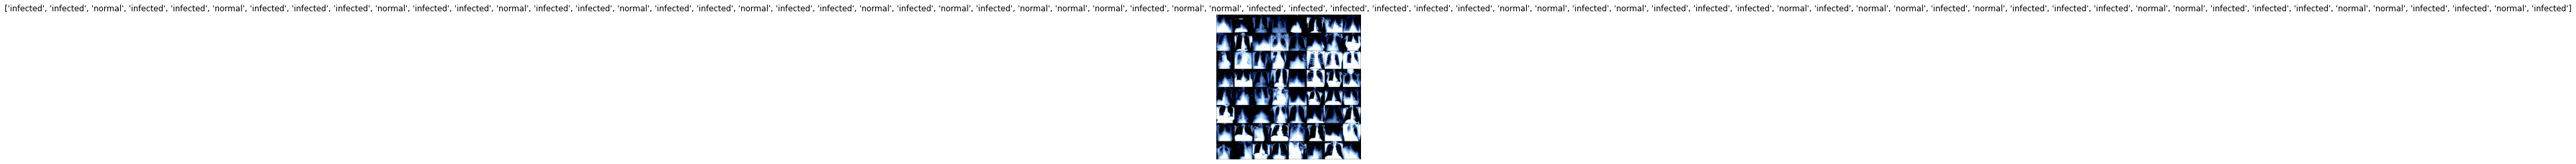

In [38]:
dataiter = iter(testloader)
images, labels = dataiter.next()
show_databatch(images, labels)

In [39]:
images, labels = images.to(device), labels.to(device) #-->convert test image to cuda (if available)
outputs = resnet18(images)                               #--> forward pass
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join('%5s' % class_names[predicted[j]]
                              for j in range(len(images))))
print('Ground Truth: ', ' '.join('%5s' % class_names[labels[j]]
                              for j in range(len(images))))

Predicted:  infected infected normal infected infected normal infected infected infected normal infected infected normal infected infected normal infected infected normal infected infected normal infected normal infected normal normal normal infected normal normal infected infected infected infected infected infected normal normal infected normal infected infected infected normal normal normal normal infected normal normal infected infected normal normal normal infected infected normal normal infected infected normal infected
Ground Truth:  infected infected normal infected infected normal infected infected infected normal infected infected normal infected infected normal infected infected normal infected infected normal infected normal infected normal normal normal infected normal normal infected infected infected infected infected infected normal normal infected normal infected infected infected normal infected normal normal infected normal infected infected infected normal normal in

In [40]:
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = resnet18(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 1500 test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the 1500 test images: 91 %


In [46]:
correct = 0
total = 0
with torch.no_grad():
    for data in validationloader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = resnet18(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 1500 test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the 1500 test images: 85 %


In [42]:
nb_classes = 2

confusion_matrix = torch.zeros(nb_classes, nb_classes)
with torch.no_grad():
    for i, (inputs, classes) in enumerate(trainloader):
        inputs = inputs.to(device)
        classes = classes.to(device)
        outputs = resnet18(inputs)
        _, preds = torch.max(outputs, 1)
        for t, p in zip(classes.view(-1), preds.view(-1)):
                confusion_matrix[t.long(), p.long()] += 1

print(confusion_matrix)

tensor([[3928.,  991.],
        [ 670., 6411.]])


In [47]:
nb_classes = 2

confusion_matrix = torch.zeros(nb_classes, nb_classes)
with torch.no_grad():
    for i, (inputs, classes) in enumerate(validationloader):
        inputs = inputs.to(device)
        classes = classes.to(device)
        outputs = resnet18(inputs)
        _, preds = torch.max(outputs, 1)
        for t, p in zip(classes.view(-1), preds.view(-1)):
                confusion_matrix[t.long(), p.long()] += 1

print(confusion_matrix)

tensor([[504., 111.],
        [106., 779.]])


In [41]:
nb_classes = 2

confusion_matrix = torch.zeros(nb_classes, nb_classes)
with torch.no_grad():
    for i, (inputs, classes) in enumerate(testloader):
        inputs = inputs.to(device)
        classes = classes.to(device)
        outputs = resnet18(inputs)
        _, preds = torch.max(outputs, 1)
        for t, p in zip(classes.view(-1), preds.view(-1)):
                confusion_matrix[t.long(), p.long()] += 1

print(confusion_matrix)

tensor([[538.,  77.],
        [ 58., 827.]])


In [52]:
from tqdm import tqdm

#if you have gpu then you need to convert the network and data to cuda
#the easiest way is to first check for device and then convert network and data to device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
resnet18.to(device)
losses_val = []
resnet18.train()

for epoch in range(Epochs):  # loop over the dataset multiple times

    running_loss = 0.0
    pbar = tqdm(enumerate(validationloader))
    for i, data in pbar:
        # get the inputs
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()
        # In PyTorch, we need to set the gradients to zero before starting to do backpropragation 
        # because PyTorch accumulates the gradients on subsequent backward passes. 
        # This is convenient while training RNNs. 
        # So, the default action is to accumulate the gradients on every loss.backward() call

        # forward + backward + optimize
        outputs = resnet18(inputs)               #----> forward pass
        loss = criterion(outputs, labels)   #----> compute loss
        loss.backward()                     #----> backward pass
        optimizer.step()                    #----> weights update

        # print statistics
        running_loss += loss.item()
        
        pbar.set_description(
            'Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, i * len(inputs), len(validationloader.dataset),
                100. * i / len(validationloader),
                loss.data))
    epoch_loss = running_loss / len(validationloader)
    losses_val.append(epoch_loss)
    
    #torch.save(resnet18.state_dict(), 'res18_FC_Only.pth')

print('Finished Training')

Train Epoch: 0 [644/1500 (96%)]	Loss: 0.559475: : 24it [00:27,  1.15s/it]
Train Epoch: 1 [644/1500 (96%)]	Loss: 0.149710: : 24it [00:26,  1.12s/it]
Train Epoch: 2 [644/1500 (96%)]	Loss: 0.454401: : 24it [00:26,  1.12s/it]
Train Epoch: 3 [644/1500 (96%)]	Loss: 0.520466: : 24it [00:26,  1.11s/it]
Train Epoch: 4 [644/1500 (96%)]	Loss: 0.339803: : 24it [00:26,  1.10s/it]
Train Epoch: 5 [644/1500 (96%)]	Loss: 0.481327: : 24it [00:26,  1.12s/it]
Train Epoch: 6 [644/1500 (96%)]	Loss: 0.447877: : 24it [00:27,  1.13s/it]
Train Epoch: 7 [644/1500 (96%)]	Loss: 0.414036: : 24it [00:26,  1.12s/it]
Train Epoch: 8 [644/1500 (96%)]	Loss: 0.603353: : 24it [00:26,  1.12s/it]
Train Epoch: 9 [644/1500 (96%)]	Loss: 0.359785: : 24it [00:26,  1.12s/it]

Finished Training


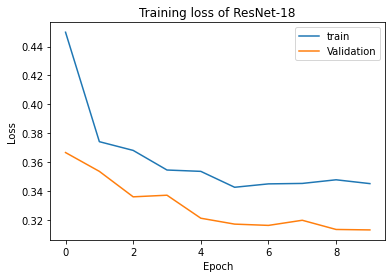

In [61]:
plt.title("Training loss of ResNet-18")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.plot(losses)
plt.plot(losses_val)
plt.legend(['train','Validation'])
plt.show()

 # **Task 2**

In [62]:
vgg16 = models.vgg16(pretrained=True)
resnet18 = models.resnet18(pretrained=True)
print(vgg16)
print('Output Layer of VGG16 : ', vgg16.classifier[6].out_features) # 1000
print('\n\n<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<   ResNet-18   >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>\n')
print('\n',resnet18)
print('Output Layer of resnet18 : ', resnet18.fc.out_features) # 1000

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [0]:
# Freeze training for all layers
for param in vgg16.features.parameters():
    param.require_grad = False

In [0]:
# Freeze training for all layers above FC in ResNet18
child_counter = 0
for child in resnet18.children():
   #print(" child", child_counter, "is:")
   #print(child)
   child_counter += 1
   if child_counter < 9:
     for param in child.parameters():
        param.requires_grad = False


In [65]:
features = [nn.Linear(in_features=25088, out_features=540, bias=True), nn.ReLU(inplace=True), nn.Dropout(p=0.5, inplace=False), nn.Linear(in_features=540, out_features=2, bias=True)]
print(features)

vgg16.classifier = nn.Sequential(*features)
print(vgg16)

[Linear(in_features=25088, out_features=540, bias=True), ReLU(inplace=True), Dropout(p=0.5, inplace=False), Linear(in_features=540, out_features=2, bias=True)]
VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Con

In [66]:
resnet18.fc = nn.Sequential(nn.Linear(512,540), nn.Linear(540, 2))
print(resnet18)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  